<a href="https://colab.research.google.com/github/JakeEisner/ECON3916-Statistical-Machine-Learning/blob/main/Assignment%201/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
# 1.1 Manual Basket Construction
student_basket = [
{'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Textbooks', 'Price_2016': 600, 'Price_2024': 900}
]

In [80]:
# 1.2 Define the "Machine" (Function)
def calculate_inflation(base,current):
  return ((current - base) / base) * 100

# Run Loop
for item in student_basket:
  rate = calculate_inflation(item["Price_2016"], item["Price_2024"])
  print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Textbooks: 50.00% Inflation


In [81]:
# Step 2.1: The Data Proxy Strategy
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key="df69d2a5b461f1a561f6216223615596")

official_cpi = fred.get_series("CPIAUCSL")
tuition = fred.get_series("CUSR0000SEEB")
rent = fred.get_series("CUSR0000SEHA")
streaming = fred.get_series("CUSR0000SERA02")
food_away = fred.get_series("CUSR0000SEFV")



In [82]:
# Step 2.2 Normalization Logic
import pandas as pd

df = pd.DataFrame({
    "CPI": official_cpi,
    "Tuition": tuition,
    "Rent": rent,
    "Streaming": streaming,
    "Food_Away": food_away
})

df = df.loc["2016-01-01":]
df_normalized = (df / df.iloc[0]) * 100
df_normalized.head()


,CPI,Tuition,Rent,Streaming,Food_Away
2016-01-01,100.000000,100.000000,100.000000,100.000000,100.000000
2016-02-01,99.867032,100.241572,100.314364,100.723912,100.138869
2016-03-01,100.180095,100.470288,100.607131,101.450163,100.355827
2016-04-01,100.563850,100.692146,100.924580,101.878663,100.599712
2016-05-01,100.801592,100.929861,101.258485,102.214306,100.813978


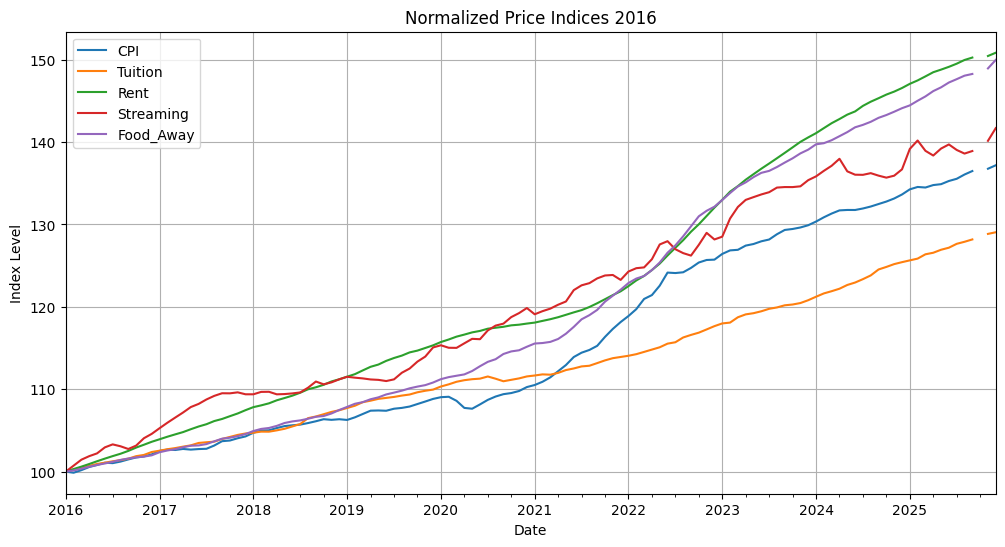

In [83]:
# 3.1 Plots
import matplotlib.pyplot as plt

df_normalized.plot(figsize=(12,6))
plt.title("Normalized Price Indices 2016")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True,)
plt.show()


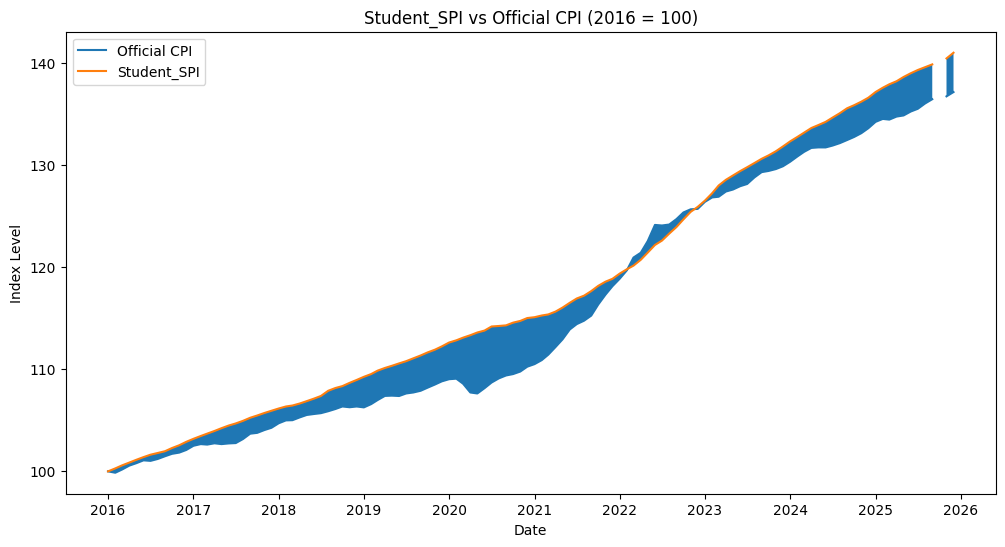

In [84]:
# Step 3.2 The Weighted "Student SPI" (Honest Chart)

#1 Weight Dictionary

weights = {
    "Tuition": 0.40,
    "Rent": 0.30,
    "Food_Away": 0.20,
    "Streaming": 0.10
}


#2 Calculate a New Column

df_normalized["Student_SPI"] = (
    df_normalized["Tuition"] * weights["Tuition"] +
    df_normalized["Rent"] * weights["Rent"] +
    df_normalized["Food_Away"] * weights["Food_Away"] +
    df_normalized["Streaming"] * weights["Streaming"]
)

#3 Plot Custom Function
plt.figure(figsize=(12,6))

plt.plot(df_normalized.index, df_normalized["CPI"], label="Official CPI")
plt.plot(df_normalized.index, df_normalized["Student_SPI"], label="Student_SPI")

plt.fill_between(
    df_normalized.index,
    df_normalized["CPI"],
    df_normalized["Student_SPI"]
)

plt.title("Student_SPI vs Official CPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.show()


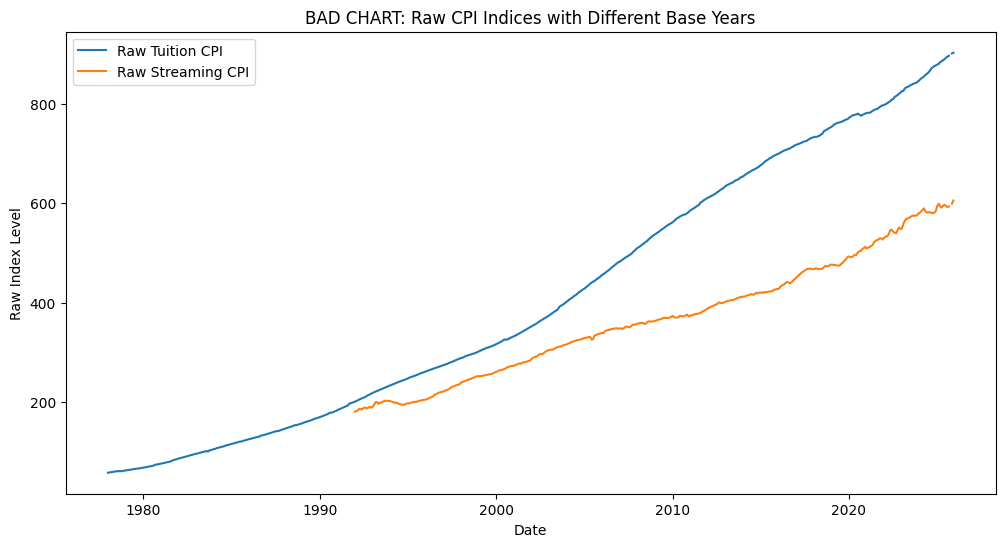

In [85]:
# 3.3 The Scale Fallacy (Why We Normalize)

plt.figure(figsize=(12,6))

plt.plot(tuition.index, tuition, label="Raw Tuition CPI")
plt.plot(streaming.index, streaming, label="Raw Streaming CPI")

plt.title("BAD CHART: Raw CPI Indices with Different Base Years")
plt.xlabel("Date")
plt.ylabel("Raw Index Level")
plt.legend()
plt.show()


This comparison is misleading because CPI series use different base years. Tuition is indexed to a much earlier base year (1982), while Streaming is indexed to a later base year (2002). As a result, the raw index levels reflect arbitrary scaling choices rather than true price growth. Comparing raw CPI indices with different base years exaggerates some categories and minimizes others, making the visual comparison meaningless. This is why normalization to a common base year is required.

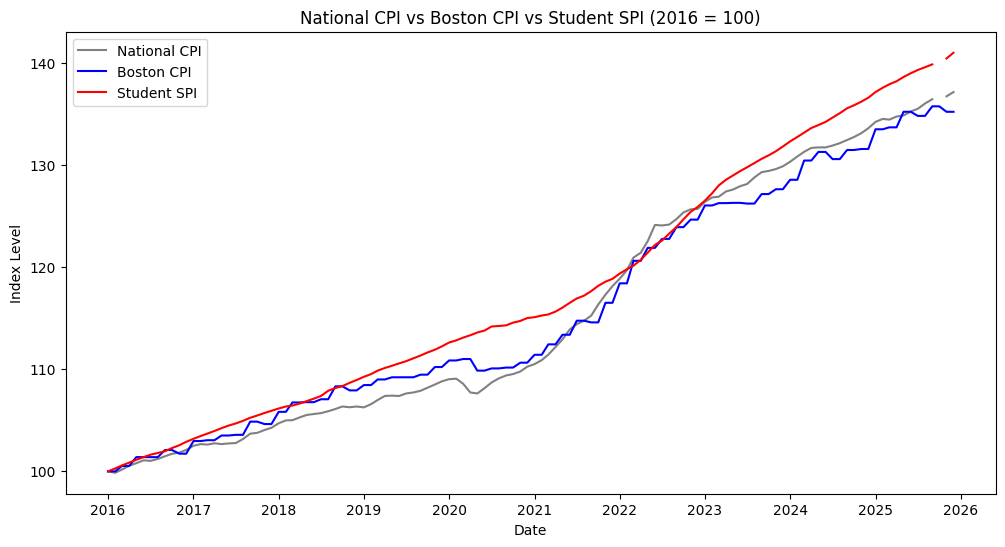

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

fred = Fred(api_key="df69d2a5b461f1a561f6216223615596")

# Boston CPI series
BOSTON_SERIES_ID = "CUURA103SA0"
boston_raw = fred.get_series(BOSTON_SERIES_ID)
boston_raw.index = pd.to_datetime(boston_raw.index)

# Normalize Boston to 2016-01-01 = 100
base_date = pd.Timestamp("2016-01-01")
base_val = boston_raw.loc[base_date] if base_date in boston_raw.index else boston_raw.loc[boston_raw.index >= base_date].iloc[0]
boston_norm = (boston_raw / base_val) * 100

# Align Boston to df_normalized's index (because Student_SPI is there)
df_normalized.index = pd.to_datetime(df_normalized.index)
boston_aligned = boston_norm.resample("MS").mean().reindex(df_normalized.index).ffill()

# Pick correct national CPI column in df_normalized (likely "CPI")
national_cpi_col = "Official_CPI" if "Official_CPI" in df_normalized.columns else "CPI"

plt.figure(figsize=(12,6))
plt.plot(df_normalized.index, df_normalized[national_cpi_col], label="National CPI", color="grey")
plt.plot(df_normalized.index, boston_aligned, label="Boston CPI", color="blue")
plt.plot(df_normalized.index, df_normalized["Student_SPI"], label="Student SPI", color="red")
plt.title("National CPI vs Boston CPI vs Student SPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.show()
